- x,y需要梯度则加上requires_grad

In [1]:
import torch  
import torch.nn as nn
# 定义区域及其上的采样  
def interior(n=1000):  
    x = torch.rand((n, 1),requires_grad=True)  
    y = torch.rand((n, 1),requires_grad=True)  
    cond = (2 - x ** 2) * torch.exp(-y)  
    return x.requires_grad_(True), y.requires_grad_(True), cond
class My_Model(nn.Module):
    def __init__(self, input_dim):
        super(My_Model,self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim,32),
            nn.ReLU(),
            nn.Linear(32,16),
            nn.ReLU()
        )
        self.linear = nn.Linear(4,1)
    def forward(self,t,x):
        x = self.model(t)
        t = self.model(t)
        x = x.squeeze(1)
        return x

In [2]:
loss = nn.MSELoss()
net = My_Model()

TypeError: My_Model.__init__() missing 1 required positional argument: 'input_dim'

- torch.cat(x, y, dim=)拼接在某个维度上拼接
- torch.autograd.grad(y, x, retain_graph)
- torch.autograd.grad(y, x, grad_outpus=)

![alt text](image.png)

In [3]:
import torch
import numpy as np
import torch.nn as nn
x = torch.rand(100,1).requires_grad_(True)
y = x**2
z = torch.ones_like(y)
dydx = torch.autograd.grad(y,x,grad_outputs=z)
print(dydx)

(tensor([[1.7973],
        [0.4858],
        [1.6940],
        [1.1492],
        [1.4340],
        [0.3113],
        [1.0138],
        [1.4027],
        [1.7174],
        [1.5697],
        [0.3805],
        [0.7866],
        [0.6863],
        [1.1495],
        [0.8085],
        [1.2394],
        [1.0290],
        [0.3159],
        [1.6696],
        [1.4203],
        [0.4424],
        [1.5433],
        [0.2578],
        [0.7568],
        [0.7882],
        [1.3035],
        [0.5447],
        [0.1198],
        [1.5584],
        [1.0547],
        [1.1132],
        [1.2330],
        [1.3161],
        [0.9062],
        [1.8112],
        [0.6152],
        [1.5403],
        [0.7876],
        [0.5531],
        [0.5999],
        [1.8995],
        [0.0150],
        [1.6293],
        [0.7685],
        [1.0408],
        [1.7640],
        [0.4069],
        [0.0031],
        [0.3134],
        [0.9056],
        [0.7334],
        [1.1584],
        [0.9181],
        [1.5305],
        [0.6219],
        [

In [4]:
import math
import torch
import numpy as np
import torch.nn as nn
from tqdm import tqdm
def sample(n):
    x = torch.rand(n,1).to(device)
    y = torch.rand(n,1).to(device)
    return x.requires_grad_(True),y.requires_grad_(True)
def lx(u):
    x,y = sample(100)
    cond = (2*x).to(device)
    xy =torch.cat([x,y],dim=1)
    f = u(xy)
    dfdx = torch.autograd.grad(f,x,retain_graph=True,grad_outputs=torch.ones_like(f),create_graph=True,only_inputs=True)[0]
    return loss(dfdx,cond)
def ly(u):
    x,y = sample(100)
    cond = (2*y).to(device)
    xy =torch.cat([x,y],dim=1)
    f = u(xy)
    dfdy = torch.autograd.grad(f,y,retain_graph=True,grad_outputs=torch.ones_like(f),create_graph=True,only_inputs=True)[0]
    return loss(dfdy,cond)

class model(nn.Module):
    def __init__(self):
        super(model, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2,32),
            nn.ReLU(),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Linear(16,1)
        )
    def forward(self,x):
        x = self.net(x)
        return x
device = 'cuda' if torch.cuda.is_available() else 'cpu'

u = model().to(device)
opt = torch.optim.Adam(params=u.parameters())
loss = torch.nn.MSELoss()
Lmin= math.inf
pbar = tqdm(list(range(30000)), desc='PINN_train_process', colour='red')
for i in pbar:
    opt.zero_grad()
    x = 100*torch.rand(1000,1).to(device)
    y = 100*torch.rand(1000,1).to(device)
    f_r = (x**2 + y**2).to(device)
    xy =torch.cat([x,y],dim=1)

    l2 = lx(u) + ly(u)
    f = u (xy).to(device)
    L = loss(f,f_r) + l2
    L.backward()
    opt.step()
    pbar.set_postfix({'Loss':L.cpu().detach().numpy()})
    if Lmin>L:
        Lmin = L
        torch.save(u.state_dict(), './x**2+y**2-models.ckpt')

u = model().to(device)
u.load_state_dict(torch.load('./x**2+y**2-models.ckpt'))
x1 = 100*torch.rand(1000,1).to(device)
y1 = 100*torch.rand(1000,1).to(device)
x1y1 = torch.cat([x1,y1],dim=1)
slove = u(x1y1)
losstest = loss(slove,(x1**2+y1**2))

In [ ]:
u = model()
u.load_state_dict(torch.load('./x**2+y**2-models.ckpt'))
x1 = 10*torch.rand(1000,1)
y1 = 10*torch.rand(1000,1)
x1y1 = torch.cat([x1,y1],dim=1)
slove = u(x1y1)
t = x1**2+y1**2
losstest = loss(slove,(x1**2+y1**2))
print(losstest)

tensor(187.5035, grad_fn=<MseLossBackward0>)


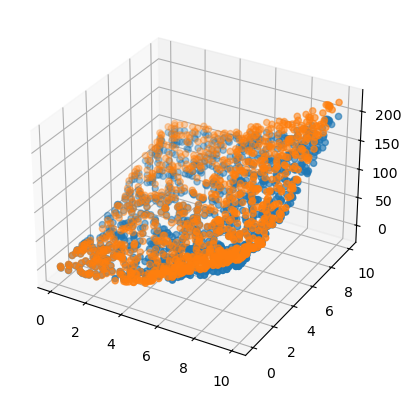

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(1)
slove = slove.detach().numpy()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1,y1,t)
ax.scatter(x1,y1,slove)
plt.show()

# 求解约束条件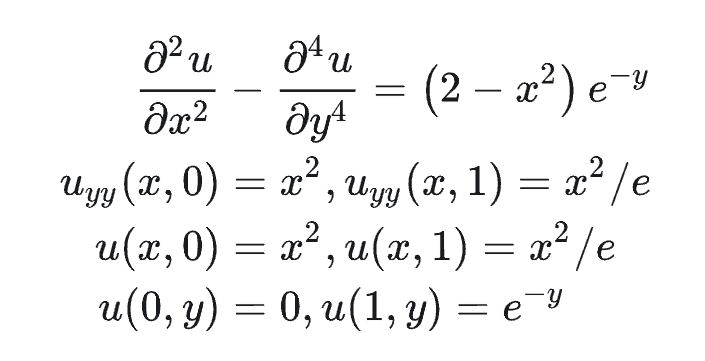

In [ ]:
import torch
from tqdm import tqdm
# Domain and Sampling
def interior(n=1000):
    x = torch.rand(n, 1).to(device)
    y = torch.rand(n, 1).to(device)
    cond = (2 - x ** 2) * torch.exp(-y).to(device)
    return x.requires_grad_(True), y.requires_grad_(True), cond


def down_yy(n=100):
    x = torch.rand(n, 1).to(device)
    y = torch.zeros_like(x).to(device)
    cond = (x ** 2).to(device)
    return x.requires_grad_(True), y.requires_grad_(True), cond


def up_yy(n=100):
    x = torch.rand(n, 1).to(device)
    y = torch.ones_like(x).to(device)
    cond = (x ** 2 / torch.e).to(device)
    return x.requires_grad_(True), y.requires_grad_(True), cond


def down(n=100):
    x = torch.rand(n, 1).to(device)
    y = torch.zeros_like(x).to(device)
    cond = (x ** 2).to(device)
    return x.requires_grad_(True), y.requires_grad_(True), cond


def up(n=100):
    x = torch.rand(n, 1).to(device)
    y = torch.ones_like(x).to(device)
    cond = (x ** 2 / torch.e).to(device)
    return x.requires_grad_(True), y.requires_grad_(True), cond


def left(n=100):
    y = torch.rand(n, 1).to(device)
    x = torch.zeros_like(y).to(device)
    cond = torch.zeros_like(x).to(device)
    return x.requires_grad_(True), y.requires_grad_(True), cond


def right(n=100):
    y = torch.rand(n, 1).to(device)
    x = torch.ones_like(y).to(device)
    cond = torch.exp(-y).to(device)
    return x.requires_grad_(True), y.requires_grad_(True), cond


# Neural Network
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(2, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)


# Loss
loss = torch.nn.MSELoss()


def gradients(u, x, order=1):
    if order == 1:
        return torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u),
                                   create_graph=True,
                                   only_inputs=True, )[0]
    else:
        return gradients(gradients(u, x), x, order=order - 1)


def l_interior(u):
    x, y, cond = interior()
    uxy = u(torch.cat([x, y], dim=1))
    return loss(gradients(uxy, x, 2) - gradients(uxy, y, 4), cond)


def l_down_yy(u):
    x, y, cond = down_yy()
    uxy = u(torch.cat([x, y], dim=1))
    return loss(gradients(uxy, y, 2), cond)


def l_up_yy(u):
    x, y, cond = up_yy()
    uxy = u(torch.cat([x, y], dim=1))
    return loss(gradients(uxy, y, 2), cond)


def l_down(u):
    x, y, cond = down()
    uxy = u(torch.cat([x, y], dim=1))
    return loss(uxy, cond)


def l_up(u):
    x, y, cond = up()
    uxy = u(torch.cat([x, y], dim=1))
    return loss(uxy, cond)


def l_left(u):
    x, y, cond = left()
    uxy = u(torch.cat([x, y], dim=1))
    return loss(uxy, cond)


def l_right(u):
    x, y, cond = right()
    uxy = u(torch.cat([x, y], dim=1))
    return loss(uxy, cond)


# Training
# device = 'cpu'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
u = MLP().to(device)
opt = torch.optim.Adam(params=u.parameters())
pbar = tqdm(list(range(20000)))
for i in pbar:
    opt.zero_grad()
    l = l_interior(u) \
        + l_up_yy(u) \
        + l_down_yy(u) \
        + l_up(u) \
        + l_down(u) \
        + l_left(u) \
        + l_right(u)
    l.backward()
    opt.step()
    pbar.set_postfix({'loss':l.cpu().detach().numpy()})

# Inference
xc = torch.linspace(2, 3, 100).to(device)
xx, yy = torch.meshgrid(xc, xc,indexing='xy')
xx = xx.reshape(-1, 1).to(device)
yy = yy.reshape(-1, 1) .to(device)
xy = torch.cat([xx, yy], dim=1).to(device)
u_pred = u(xy)
u_true = xx * xx * torch.exp(-yy).to(device) 
print("Max abs error is: ", float(torch.max(torch.abs(u_pred - u_true))))